In [420]:
using LinearAlgebra
using PyPlot
using RandomMatrix
using ITensors
using TensorOperations
using LsqFit

# Numerical many-body methods - Problem Set 2 
## (Entanglement Entropy and MPS)
Noam Ophir

# Ex. 1 - Entanglement entropy

*Given a state of spin-1/2's on a chain of length $L$ (i.e. a vector of length 2L) consider a bi-partition in which all odd sites belong to subsystem $A$, and all even sites to subsystem $B$. Calculate the entanglement entropy of a random state upon such bi-partition.*

In [39]:
L = 16

function SvN_even_odd(psi)
    
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD)                                                                           # length of the chain
    
    psi_matrix = reshape(psi,(fill(2, L)...))                                               # decouple each spin's DOF
    psi_matrix = permutedims(psi_matrix,vcat(collect(1:2:L), collect(2:2:L)))               # reorginze the basis to (odds, evens)
    psi_matrix = reshape(psi_matrix,(2^length(collect(1:2:L)),2^length(collect(2:2:L))))    # reshape it back to a matrix form
    
    U,s,V = svd(psi_matrix)
    s = s[s .> 1e-14]                                                                       # choosing non-zero singular values
    w = s.^2
    return -sum(w.*log.(w))
end

SvN_even_odd (generic function with 1 method)

### Ex1 Sanity check

In [62]:
L = 12
dim = 2^L
psi = rand(dim)
psi ./= norm(psi)
@show SvN_even_odd(psi)

psi = zeros(dim)
psi[1] = 1
@show SvN_even_odd(psi)

SvN_even_odd(psi) = 1.425824889519255
SvN_even_odd(psi) = -0.0


-0.0

# Ex.2 - 1D Transverse Field Ising Model (TFIM)

*In this problem we will consider the transverse field Ising model in 1D, focusing on the entanglement properties of the ground state. Recall that the model is given by the following Hamiltonian*
$$H=-J\sum_i\sigma^z_i\sigma^z_{i+1}-h\sum_i\sigma^x_i$$
*where $\sigma^\alpha$ are Pauli matrices, and is known to exhibit a phase transition between a ferromagnetic state at $h/J < 1$, to a paramagnetic one at $h/J > 1$. To obtain the ground state of the system we will use the imaginary-time TEBD method discussed in class. Throughout the question use maximal bond dimension of $M = 20$ and imaginary time step of $dt = 0.1$. You can use the Néel MPS as the initial states.*

## 2-1 Ferromagnetic phase
*Consider the ground state of the system deep in the ferromagnetic phase, e.g. for $h/J = 0.5$. Here you can use system sizes of few tens of sites and  $\beta\simeq10$.*
1. *Calculate and plot the local expectation value of $S^z$ along the chain (i.e. $S^z_i$ for $i = 1,...,L$) in the ground state. Does it fit your expectations?*
2. *Calculate and plot the correlations $S^z_1 S^z_i$ (as function of $i$).*
3. *Calculate the von Neumann entropy across the central bond, as function of system size. Does the scaling with system size fit your expectations?*

In [70]:
mutable struct MPSrep
    oc::Int64                        # orthogonality center
    maxM::Int64                      # maximal bond dimension
    state::Vector{Array{Float64}}  
    
    function MPSrep(psi::Vector{Float64}, maxM=-1)
        # initial MPS given in left-canonical form, oc at rightmost site
        state, VN, Ms, Trunc = MPSrep_LC(psi, maxM)
        oc = length(state)
        new(oc, maxM, state)
    end
    
    function MPSrep(psi::Vector{Array{Float64}})
        # initial MPS given in right-canonical form, oc at leftmost site
        oc = 1
        maxM = -1
        state = deepcopy(psi)
        new(oc, maxM, state)
    end
    
end

In [660]:
# Functions from the tutorial
function NeelMPS(L::Int64)
    # Initialize an array to store matrices representing the Neel state MPS.
    psi = Array{Float64}[]

    # Iterate through each site in the 1D quantum system.
    for i in 1:L
        # Check if the site index is odd (spin-up) or even (spin-down).
        if isodd(i)
            # For spin-up, add a matrix with coefficients [1.0, 0.0] to the array.
            push!(psi, reshape([1.0, 0.0], (1, 2, 1)))
        else
            # For spin-down, add a matrix with coefficients [0.0, 1.0] to the array.
            push!(psi, reshape([0.0, 1.0], (1, 2, 1)))
        end
    end

    # Return the array representing the Neel state MPS.
    return psi
end

function NormalizePsi!(psi::Vector{Array{Float64}})
    """
    NormalizePsi!(psi::Vector{Array{Float64}})

    Normalize and bring the orthogonality center to the first site in a Matrix Product State (MPS), assuming right canonical form.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    """
    L = length(psi)

    # Iterate from the last site to the second site
    for i in L-1:-1:1
        # Calculate the bond tensor between current site i and i+1
        psi_bond = BondTensor(psi, i)

        # Orthogonally update the MPS using the Singular Value Decomposition (SVD), assuming right canonical form
        SvdBondTensor!(psi, i, psi_bond, false, -1, true)
        # ortho_left = false => Update the matrix at site i+1 (right canonical form)
        # maxM = -1 => No truncation
        # renorm = true => Renormalize the singular values
    end
end

function BondTensor(psi::Vector{Array{Float64}}, b::Int64)
    """
    BondTensor(psi::Vector{Array{Float64}}, b::Int64)

    Construct the bond tensor between two adjacent sites in a Matrix Product State (MPS).

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).

    # Returns
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.

    """
    @assert b >= 1 && b <= (length(psi)-1) "Bond out of range"

    # Dimensions of matrices at site b and site b+1
    M0 = size(psi[b])[1]
    M2 = size(psi[b+1])[3]

    # Initialize the bond tensor
    psi_bond = zeros(M0, 2, 2, M2)

    # Contract matrices at site b and site b+1 to form the bond tensor
    @tensor psi_bond[l0, s1, s2, l2] = psi[b][l0, s1, l1] * psi[b+1][l1, s2, l2]

    return psi_bond
end

function SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)
    """
    SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)

    Update the Matrix Product State (MPS) by performing a Singular Value Decomposition (SVD) on the bond tensor.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.
    - `ortho_left`: If true, orthogonally update the matrix at site `b` (left-canonical). If false, orthogonally update the matrix at site `b+1` (right-canonical).
    - `maxM`: The maximum number of singular values to keep in each step. If -1, no truncation is performed.
    - `renorm`: If true, renormalize the singular values after the SVD.

    # Returns
    - `trunc`: Truncation error if truncation occurs, otherwise 0.

    """
    @assert length(size(psi_bond)) == 4 "psi_bond is expected to be a rank-4 tensor"

    trunc = 0.

    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*2, M2*2))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)

    # Optionally renormalize the singular values
    if renorm
        S /= norm(S)
    end

    # Find the last non-zero singular value
    M1 = findlast(S .> 1e-16)

    # Retain only relevant parts of U, S, and V
    U, S, V = U[:, 1:M1], S[1:M1], V[:, 1:M1]

    # If 0 < maxM < M1 - truncation, perform truncation
    if maxM > 0 && M1 > maxM
        trunc = sum(S[maxM:end].^2)
        U, S, V = U[:, 1:maxM], S[1:maxM], V[:, 1:maxM]
        S /= sqrt(1. - trunc)
        M1 = maxM
    end

    # Update the MPS matrices based on the SVD results
    if ortho_left
        psi[b] = reshape(U, (M0, 2, M1))
        psi[b+1] = reshape(Diagonal(S) * V', (M1, 2, M2))
    else
        psi[b] = reshape(U * Diagonal(S), (M0, 2, M1))
        psi[b+1] = reshape(V', (M1, 2, M2))
    end

    return trunc
end

function OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)
    """
    OrthogonalizePsi!(psi_mps::MPSrep, i0::Int64)

    Bring the orthogonality center to site i0 in a Matrix Product State (MPS), updating the MPS representation.

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `i0`: The target site to which the orthogonality center (oc) should be moved.

    """
    L = length(psi_mps.state)
    oc = psi_mps.oc

    if i0 > oc
        # Move the orthogonality center to the right: Add more left canonical forms
        for i in oc:i0-1
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = true => Update the matrix at site i (left canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, true)
        end
    elseif i0 < oc
        # Move the orthogonality center to the left
        for i in oc-1:-1:i0
            psi_bond = BondTensor(psi_mps.state, i)
            # ortho_left = false => Update the matrix at site i+1 (right canonical form)
            # maxM = -1 => No truncation
            # renormalize = false => Do not renormalize the singular values
            SvdBondTensor!(psi_mps.state, i, psi_bond, false)
        end
    end

    # Update the orthogonality center
    psi_mps.oc = i0
end

function ExpectationValue(psi_mps::MPSrep, Op)
    """
    ExpectationValue(psi_mps::MPSrep, Op)

    Calculate the expectation values of an operator (Op) for each site in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the expectation values.

    # Returns
    An array of expectation values for each site.

    """
    L = length(psi_mps.state)
    ExpVals = zeros(L)

    for i in 1:L
        # Orthogonalize the MPS up to site i
        OrthogonalizePsi!(psi_mps, i)

        # Extract the matrix Ai from the MPS representation at site i
        Ai = psi_mps.state[i]
        M0 = size(Ai)[1]
        M1 = size(Ai)[3]

        # Initialize the tensor representing Ai * Op
        Ai_Sop = zeros(M0, 2, M1)

        # Contract Ai with Op to obtain Ai_Sop tensor
        @tensor Ai_Sop[l0, sp, l1] = Ai[l0, s, l1] * Op[s, sp]

        # Calculate the expectation value
        @tensor Val = Ai_Sop[l0, sp, l1] * Ai[l0, sp, l1]
        ExpVals[i] = Val
    end

    return ExpVals
end

function CorrelationsByLength(psi_mps::MPSrep, Op)
    """
    CorrelationsByLength(psi_mps::MPSrep, Op)

    Calculate correlations by length for an operator (Op) in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the correlations.

    # Returns
    An array of correlation values for each site.

    """
    i0 = 1
    Corr = []

    # Move the orthogonality center to the first site
    OrthogonalizePsi!(psi_mps, i0)
    Ai0 = psi_mps.state[i0]
    M0 = size(Ai0)[1]
    M1 = size(Ai0)[3]

    # Initialize tensors for Ai * Op
    Ai_Sop = zeros(M0, 2, M1)
    @tensor Ai_Sop[l0, sp, l1] = Ai0[l0, s, l1] * Op[s, sp]

    # Calculate Ai * Op * Ai'
    Ai0Ai0p = zeros(M1, M1) #! correction2
    @tensor Ai0Ai0p[l1, l1p] = Ai_Sop[l0, sp, l1] * Ai0[l0, sp, l1p] #! correction2

    for j0 in 2:L
        AiAip = deepcopy(Ai0Ai0p) #! correction2
        # Iterate from i0+1 to j0-1
        for k in i0+1:j0-1
            Ak = psi_mps.state[k]
            M2 = size(Ak)[3]
            M1 = size(AiAip)[1] #! correction1
            
            # Initialize tensors for AiAip * Ak
            AiAip_Ak = zeros(M1, 2, M2)
            
            @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Ak[l1, s, l2]

            # Calculate AiAip * Ak * AiAip'
            AiAip = zeros(M2, M2)
            @tensor AiAip[l2, l2p] = AiAip_Ak[l1p, s, l2] * Ak[l1p, s, l2p]

            # Update M1 for the next iteration
            M1 = M2
        end

        Aj0 = psi_mps.state[j0]
        M2 = size(Aj0)[3]

        # Initialize tensors for AiAip * Ak * Op
        AiAip_Ak = zeros(M1, 2, M2)
        @tensor AiAip_Ak[l1p, s, l2] = AiAip[l1, l1p] * Aj0[l1, s, l2]
        AiAip_Ak_Op = zeros(M1, 2, M2)
        @tensor AiAip_Ak_Op[l1p, sp, l2] = AiAip_Ak[l1p, s, l2] * Op[s, sp]
        println(AiAip_Ak_Op)
        # Calculate AiAip * Ak * Op * Aj0'
        @tensor Val = AiAip_Ak_Op[l1p, sp, l2] * Aj0[l1p, sp, l2]

        # Store the correlation value
        push!(Corr, Val)
    end

    return Corr
end

function BondH(h1::Float64, h2::Float64)
    """
    BondH(h1::Float64, h2::Float64)

    Generate the bond Hamiltonian matrix for a two-site bond in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The Hamiltonian matrix for the two-site bond in the TFIM.

    """
    # Pauli matrices
    Sx = [0.0 1.0; 1.0 0.0]
    Sz = [1.0 0.0; 0.0 -1.0]
    Id = [1.0 0.0; 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = -kron(Sz, Sz) - h1 * kron(Sx, Id) - h2 * kron(Id, Sx)
    
    return Hb
end

function GateTensor(dt::Float64, h1::Float64, h2::Float64)
    """
    GateTensor(dt::Float64, h1::Float64, h2::Float64)

    Generate the gate tensor for a time evolution step in the Transverse Field Ising Model (TFIM).

    # Arguments
    - `dt`: Time step for the evolution.
    - `h1`: Coefficient for the Sx⨂Id term.
    - `h2`: Coefficient for the Id⨂Sx term.

    # Returns
    The gate tensor for the time evolution step in the TFIM.

    """
    # Generate the Hamiltonian matrix for the two-site bond in the TFIM
    Hb = BondH(h1, h2)

    # Construct the gate tensor for the time evolution step using the Hamiltonian
    G = exp(-dt/2 * Hb)

    # Reshape the gate tensor to a 4-index tensor
    return reshape(G, (2, 2, 2, 2))
end

function ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)
    """
    ApplyGate!(psi::Vector{Array{Float64}}, op::Array{Float64}, b::Int64, ortho_left=true, maxM=-1, renorm=false)

    Apply a gate to a specific bond in the Matrix Product State (MPS) representation.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `op`: Array representing the gate to be applied.
    - `b`: Index of the bond where the gate is applied.
    - `ortho_left`: If true, update the left canonical form after applying the gate. Default is true.
    - `maxM`: Maximum bond dimension. If -1, no truncation is performed. Default is -1.
    - `renorm`: If true, renormalize singular values after applying the gate. Default is false.

    # Returns
    The truncation error if truncation is performed.

    """
    trunc = 0.

    # Calculate the bond tensor for the current bond
    psi_bond = BondTensor(psi, b)

    # Initialize a new bond tensor after applying the gate
    new_psi_bond = zeros(size(psi_bond))
    
    # Contract the gate with the current bond tensor to obtain the new bond tensor
    @tensor new_psi_bond[l0, s1p, s2p, l2] = op[s2p, s1p, s2, s1] * psi_bond[l0, s1, s2, l2]

    # Update the MPS by applying the new bond tensor
    trunc = SvdBondTensor!(psi, b, new_psi_bond, ortho_left, maxM, renorm)

    return trunc
end

function iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)
    """
    iTEBD_sweep!(psi::Vector{Array{Float64}}, dt::Float64, h::Float64, maxM::Int64)

    Perform a single sweep of the imaginary time evolution using Time-Evolving Block Decimation (iTEBD).

    # Arguments
    - `psi`: Array of matrices representing the Matrix Product State (MPS).
    - `dt`: Time step for the evolution.
    - `h`: Transverse field strength.
    - `maxM`: Maximum bond dimension.

    # Returns
    The maximum truncation error during the sweep.

    """
    L = length(psi)
    
    maxTrunc = 0.

    # Sweep right
    for i in range(1, stop=L-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the right, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, true, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    # Sweep left
    for i in range(L-1, stop=1, step=-1)
        h1 = i == 1 ? h : h / 2
        h2 = i == L-1 ? h : h / 2
        gateOp = GateTensor(dt, h1, h2)
        
        # Apply the gate, update orthogonality center to the left, and renormalize
        trunc = ApplyGate!(psi, gateOp, i, false, maxM, true)
        
        # Update the maximum truncation error
        if trunc > maxTrunc
            maxTrunc = trunc
        end
    end
    
    return maxTrunc
end

iTEBD_sweep! (generic function with 1 method)

In [661]:
function CalculateGS(initial_psi::MPSrep, beta::Float64, dt::Float64, h::Float64, maxM::Int64)
    psi = deepcopy(initial_psi)
    Nt = Int(beta/dt)
    for _ = 1:Nt
        trunc = iTEBD_sweep!(psi.state, dt, h, maxM)
    end
    # NormalizePsi!(psi.state)
    return psi
end

CalculateGS (generic function with 2 methods)

In [662]:
L = 30
psi0 = NeelMPS(L)
psi0 = MPSrep(psi0)

h = 0.5
beta = 10.
dt = 0.1
maxM = 20

@time psi = CalculateGS(psi0, beta, dt, h, maxM)

Sz = [1.0 0.0; 0.0 -1.0]

@time expvalSz = ExpectationValue(psi, Sz)
@time corrSz = CorrelationsByLength(psi, Sz);

  1.658392 seconds (491.34 k allocations: 728.705 MiB, 11.32% gc time)
  0.056356 seconds (74.42 k allocations: 7.207 MiB, 91.55% compilation time)
[-0.20752799971153288 -0.20751166616543343; -0.2551917632490832 0.25518781597677925]

[-0.22940716549957174 0.2294061125552882; -0.1749351373887125 -0.17494324816175613]

[-0.004703083019698326 0.0047033010755993445; 0.0021451390742150815 0.0021451292283503646]

[-0.004189091515408205 -0.004189026719096866; 0.0011848756532401407 -0.0011847823972884605]
[-0.1931023042627993 -0.19307841325162972; -0.24734868411738625 0.2473451521096541; -0.002002510007454686 0.0020025049056951057; -0.0009829345271963837 -0.000982843009218176]

[-0.2380045145404023 0.23800249002875887; -0.18103532913162945 -0.18105078259477975; -0.0013947593389954784 -0.001394904636826363; -0.0011207047737977528 0.00112071519922483]

[-0.004567048269987744 0.004567438485858612; 0.0030701630674493017 0.0030701266167006613; 3.423235332447187e-5 3.423266271345703e-5; -1.123637485

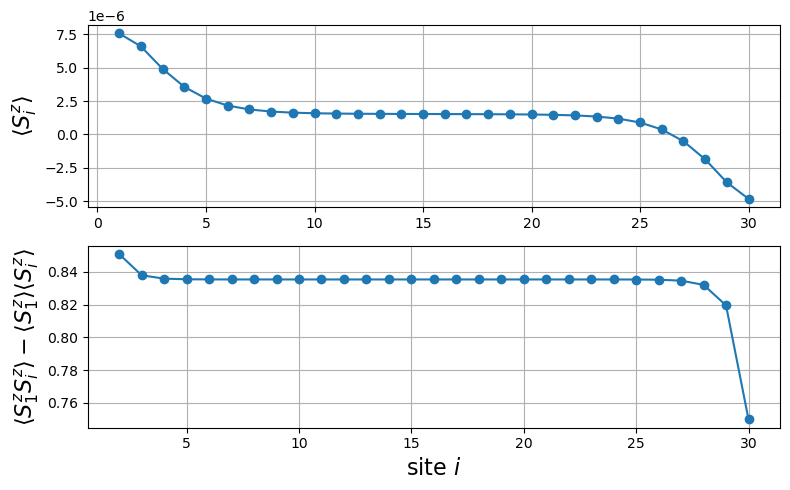

In [499]:
fig, ax = subplots(2,1,figsize=(8,5))
ax[1].plot(1:L, expvalSz, "-o")
ax[1].set_ylabel(L"\langle S^z_i\rangle", fontsize=16)
ax[1].grid()

ax[2].plot(2:L, corrSz .- expvalSz[1]*expvalSz[2:end] , "-o")
ax[2].set_ylabel(L"$\langle S^z_1 S^z_i\rangle - \langle S^z_1\rangle\langle S^z_i\rangle$", fontsize=16)
ax[2].grid()

ax[2].set_xlabel(L"site $i$", fontsize=16)
tight_layout()

In [412]:
### Working but exponentially unefficient
function recovering_state(psiMPS)
    L = length(psiMPS)
    state = reshape(psiMPS[1],(2,size(psiMPS[1])[3]))
    for i = 2:L
        M = size(psiMPS[i])[3]

        statep = zeros(2^(i-1),2,M)

        @tensor statep[s, si, M] = state[s, m] * psiMPS[i][m, si, M]
        state = reshape(statep,(2*size(statep)[1],M))
    end
    return reshape(state, 2^L)
end

function SvN(psi::MPSrep) 
    L = length(psi.state)
    i0 = Int64(div(L,2))
    psi_vec = recovering_state(psi.state)
    psi_matrix = reshape(psi_vec,(2^i0,2^(L-i0)))

    U,s,V = svd(psi_matrix)
    s = s[s .> 1e-14]                                                                       # choosing non-zero singular values
    w = s.^2
    return -sum(w.*log.(w))
end

### Working and more claver as the MPS already curries the partition
function SvN_mps(psi::MPSrep)
    L = length(psi.state)
    i0 = Int64(div(L,2))
    OrthogonalizePsi!(psi, i0)
    ML,s,MR = size(psi.state[i0])
    U, S, V = svd(reshape(psi.state[i0], (ML*s,MR)))
    S = S[S .> 1e-14]
    w = S.^2
    return -sum(w.*log.(w))
    
end

SvN_mps (generic function with 1 method)

In [413]:
Ls = 6:4:24
entropy = zeros(length(Ls))
entropy2 = zeros(length(Ls))
for (i,L) in enumerate(Ls)
    psi0 = NeelMPS(L)
    psi0 = MPSrep(psi0)
    h = 0.5
    beta = 10.
    dt = 0.01
    maxM = 20
    @time psi = CalculateGS(psi0, beta, dt, h, maxM)

    @time entropy[i] = SvN(psi)
    @time entropy2[i] = SvN_mps(psi)
end

  0.232074 seconds (810.02 k allocations: 147.318 MiB, 14.73% gc time)
  0.000047 seconds (43 allocations: 11.141 KiB)
  0.000037 seconds (64 allocations: 18.031 KiB)
  1.033246 seconds (1.47 M allocations: 697.243 MiB, 13.33% gc time)
  0.000124 seconds (60 allocations: 103.797 KiB)
  0.000164 seconds (110 allocations: 100.734 KiB)
  2.871035 seconds (2.16 M allocations: 1.898 GiB, 13.14% gc time)
  0.003996 seconds (87 allocations: 1.549 MiB)
  0.000501 seconds (156 allocations: 302.141 KiB)
  5.310974 seconds (2.84 M allocations: 3.168 GiB, 11.50% gc time)
  0.066921 seconds (109 allocations: 24.570 MiB, 11.47% gc time)
  0.000801 seconds (202 allocations: 528.672 KiB)
  7.160856 seconds (3.53 M allocations: 4.439 GiB, 11.61% gc time)
  2.176799 seconds (129 allocations: 392.258 MiB, 4.81% gc time)
  0.001840 seconds (248 allocations: 755.203 KiB)


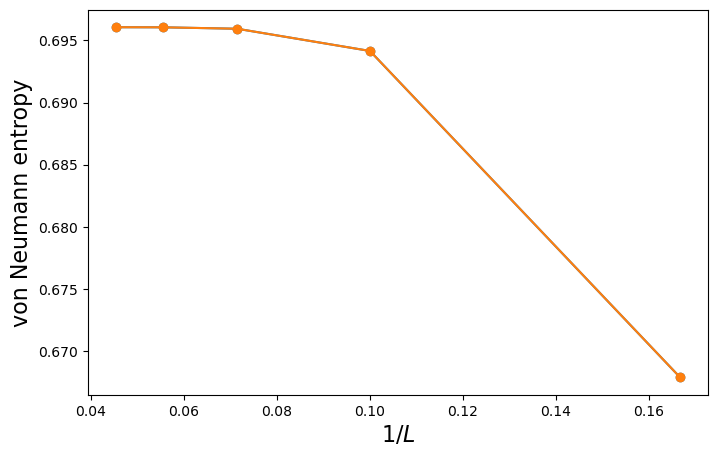

PyObject Text(33.000000000000014, 0.5, 'von Neumann entropy')

In [414]:
fig, ax = subplots(figsize=(8,5))

ax.plot(1 ./ Ls, entropy, "-o", label="method 1")
ax.plot(1 ./ Ls, entropy2, "-o", label="method 2")
ax.set_xlabel(L"$1/L$", fontsize=16)
ax.set_ylabel("von Neumann entropy", fontsize=16)

#### Verbal answer

The expectation value of $S^z_i$ fits my expectations as in quantum Ising model the ground state is a singlet state of $|\uparrow\uparrow\cdots\uparrow\rangle$ and $|\downarrow\downarrow\cdots\downarrow\rangle$, thus the expectation value of a single spin is 0, as the total spin is 0. The system has a long range order, as can be seen in the correlations plot.

The entropy saturates as the system's size grows, which exactly fits to the area law.

## 2-2 Paramagnetic phase
*Consider the ground state of the system deep in the ferromagnetic phase, e.g. for $h/J = 1.5$. Here you can use system sizes of few tens of sites and  $\beta\simeq10$.*
1. *Calculate and plot the local expectation value of $S^z$ along the chain (i.e. $S^x_i$ for $i = 1,...,L$) in the ground state. Does it fit your expectations?*
3. *Calculate the von Neumann entropy across the central bond, as function of system size. Does the scaling with system size fit your expectations?*

In [399]:
L = 30
psi0 = NeelMPS(L)
psi0 = MPSrep(psi0)

h = 1.5
beta = 10.
dt = 0.1
maxM = 20

@time psi = CalculateGS(psi0, beta, dt, h, maxM)

Sx = [0.0 1.0; 1.0 0.0]

@time expvalSx = ExpectationValue(psi, Sx)
@time corrSx = CorrelationsByLength(psi, Sx);

  1.615512 seconds (492.77 k allocations: 754.671 MiB, 10.19% gc time)
  0.004801 seconds (1.38 k allocations: 2.864 MiB)
[-0.6752345587458082 -0.6752347489646892; -0.019822405343027198 0.019822451131064105]

[0.12127273654692496 -0.12127268224743369; 0.007116764018805942 0.007116768643491913]

[-0.0009639500592477553 0.00096395068565131; 0.0005044288681773367 0.0005044286423208773]

[9.368844376827392e-5 9.368866018045374e-5; -9.800520027408564e-5 9.800522788292067e-5]
[-0.6357109557205176 -0.6357112319121361; 0.017898282225215164 -0.01789826223614486; -0.00031464137008766125 0.0003146418463019408; 0.00018141960491246104 0.0001814197070333699]

[0.11454275980990901 -0.1145427113091241; -0.006468208307553803 -0.006468200530205028; 0.00013069237298126733 0.00013069237799987157; -3.316649168493833e-5 3.316648679855951e-5]

[-0.0013801809542420486 0.001380180488310706; -0.00044533500496906183 -0.00044533486800452034; 1.314006177555281e-5 1.3140055263421126e-5; 2.443385822093937e-7 -2.4433

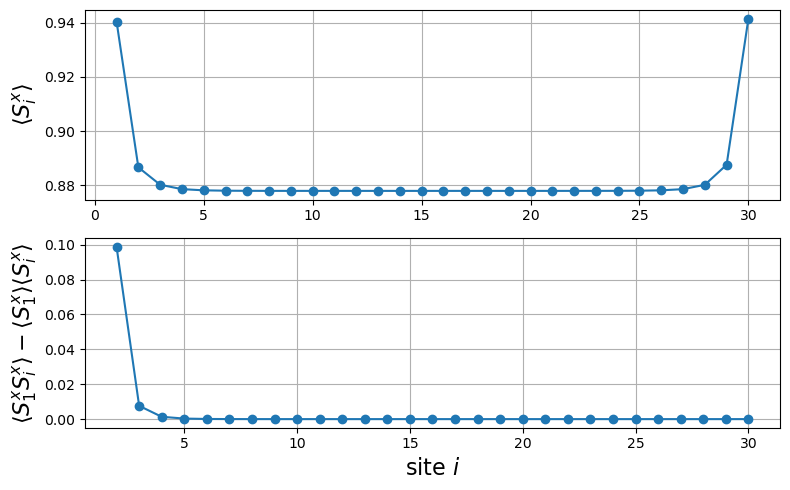

In [404]:
fig, ax = subplots(2,1,figsize=(8,5))
ax[1].plot(1:L, expvalSx, "-o")
ax[1].set_ylabel(L"\langle S^x_i\rangle", fontsize=16)
ax[1].grid()

ax[2].plot(2:L, corrSx .- expvalSx[1]*expvalSx[2:end], "-o")
ax[2].set_ylabel(L"\langle S^x_1 S^x_i\rangle - \langle S^x_1\rangle \langle S^x_i\rangle", fontsize=16)
ax[2].grid()

ax[2].set_xlabel(L"site $i$", fontsize=16)
tight_layout()

In [415]:
Ls = 6:4:24
entropy = zeros(length(Ls))
for (i,L) in enumerate(Ls)
    psi0 = NeelMPS(L)
    psi0 = MPSrep(psi0)
    h = 1.5
    beta = 10.
    dt = 0.1
    maxM = 20
    @time psi = CalculateGS(psi0, beta, dt, h, maxM)

    @time entropy[i] = SvN_mps(psi)
end

  0.024483 seconds (81.02 k allocations: 14.729 MiB)
  0.000083 seconds (64 allocations: 18.031 KiB)
  0.386392 seconds (146.90 k allocations: 71.360 MiB, 74.14% gc time)
  0.000290 seconds (110 allocations: 100.734 KiB)
  0.329490 seconds (216.06 k allocations: 202.546 MiB, 14.16% gc time)
  0.000525 seconds (156 allocations: 302.141 KiB)
  0.596198 seconds (285.23 k allocations: 340.674 MiB, 10.57% gc time)
  0.000896 seconds (202 allocations: 528.672 KiB)
  0.757110 seconds (354.41 k allocations: 478.729 MiB, 11.39% gc time)
  0.001612 seconds (248 allocations: 755.203 KiB)


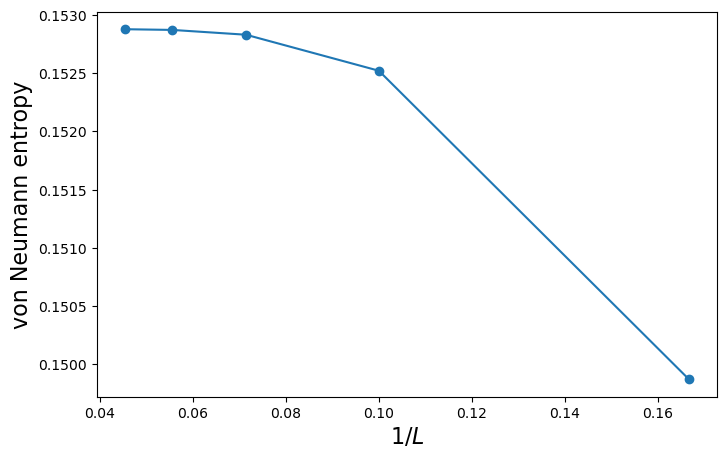

PyObject Text(33.000000000000014, 0.5, 'von Neumann entropy')

In [416]:
fig, ax = subplots(figsize=(8,5))

ax.plot(1 ./ Ls, entropy, "-o")
ax.set_xlabel(L"$1/L$", fontsize=16)
ax.set_ylabel("von Neumann entropy", fontsize=16)

#### Verbal answer

The expectation value of $S^x_i$ fits my expectations as in this region the GS is polarized and has a finite expectation value. 

The entropy saturates as the system's size grows, which exactly fits to the area law.

## 2-3 Critical point
*Now focus on the phase transition point $h/J = 1$. Consider system sizes of varying length up to $L = 100$ sites and once again calculate the entanglement entropy across the central bond. (Make sure that the entanglement entropy reached saturation, for this you might have to go to imaginary times as large as $\beta  = 100$.)*

*For a critical point described by a conformal field theory (CFT) we expect the entanglement entropy to admit the scaling*
$$S_{vN}=\frac{c}{6}\log(L)+\mathrm{const}$$
*where $c$ is the central charge (see Calabrese and Cardy, J. Stat. Mech. (2004) ). Check that this is indeed the scaling for the TFIM at the phase transition point and calculate the central charge in this case. (Hint: you should get a fractional value indicating that the gapless degrees of freedom at the critical point are Majorana modes).*

In [665]:
Ls = 20:10:100
entropy = zeros(length(Ls))
for (i,L) in enumerate(Ls)
    psi0 = NeelMPS(L)
    psi0 = MPSrep(psi0)
    h = 1.0
    beta = 100.
    dt = 0.1
    maxM = 20
    @time psi = CalculateGS(psi0, beta, dt, h, maxM)

    @time entropy[i] = SvN_mps(psi)
end

  7.634701 seconds (3.21 M allocations: 4.234 GiB, 12.33% gc time)
  0.002217 seconds (225 allocations: 641.938 KiB)
 14.047568 seconds (4.95 M allocations: 7.801 GiB, 11.67% gc time)
  0.002087 seconds (340 allocations: 1.180 MiB)
 21.832137 seconds (6.69 M allocations: 11.371 GiB, 10.77% gc time)
  0.003340 seconds (455 allocations: 1.733 MiB)
 32.575940 seconds (8.42 M allocations: 14.945 GiB, 9.55% gc time)
  0.004220 seconds (570 allocations: 2.286 MiB)


In [ ]:
fig, ax = subplots(figsize=(8,5))

ax.plot(Ls, entropy, "-o")
ax.set_xlabel(L"$L$", fontsize=16)
ax.set_ylabel("von Neumann entropy", fontsize=16)
ax.xscale("log")

LoadError: KeyError: key :xsacle not found

In [427]:
m(x, p) = p[1] .* log.(x) ./ 6 .+ p[2]
fit = curve_fit(m, Ls,entropy, [0.1,0.1])

@show central_charge = fit.param[1]

central_charge = fit.param[1] = 0.5138602053831117


0.5138602053831117

# Ex 3 - AKLT model

*In the tutorial you discussed the spin-1 bilinear-biquadratic model*
$$H
=
\sum_i
J_1 
\vec{S}_i
\cdot
\vec{S}_{i+1}
+
J_2
\left(
    \vec{S}_i
    \cdot
    \vec{S}_{i+1}
    \right)^2
$$
*As you've seen at the special point $J_2/J_1 = 1/3$ the model is exactly solvable and the ground state wavefunction can be written as an MPS of bond dimension 2, with the following tensors on each site:*
$$
A^+
=\begin{pmatrix} 0 & \sqrt{\frac{2}{3}} \\ 0 & 0\end{pmatrix}
\quad
A^0
=\begin{pmatrix} -\frac{1}{\sqrt{3}} & 0 \\ 0&\frac{1}{\sqrt{3}} \end{pmatrix}
\quad
A^-
=\begin{pmatrix} 0 & 0 \\ -\sqrt{\frac{2}{3}} & 0\end{pmatrix}
$$
*In this problem we will consider a system with open boundary conditions (OBC) and show that the ground state in this case is 4-fold degenerate, hosting fractionalized spin-1/2 edge modes.*

## 3-1
*Consider the four states obtained when left (right) boundary tensors are given by the first/second row (column) of the matrices $A$ above, i.e.*
$$
A^+_1=\begin{pmatrix}0&\sqrt{\frac{2}{3}} \end{pmatrix}
\; 
A^0_1=\begin{pmatrix} -\frac{1}{\sqrt{3}} & 0 \end{pmatrix}
\; 
A^-_1=\begin{pmatrix} 0& 0 \end{pmatrix}
\; 
A^+_L=\begin{pmatrix} 0 \\ 0 \end{pmatrix}
\;
A^0_L=\begin{pmatrix} -\frac{1}{\sqrt{3}} \\ 0 \end{pmatrix}
\;
A^-_L=\begin{pmatrix} 0 \\ -\sqrt{\frac{2}{3}} \end{pmatrix}
$$
$$
A^+_1=\begin{pmatrix}0&\sqrt{\frac{2}{3}} \end{pmatrix}
\; 
A^0_1=\begin{pmatrix} -\frac{1}{\sqrt{3}} & 0 \end{pmatrix}
\; 
A^-_1=\begin{pmatrix} 0& 0 \end{pmatrix}
\; 
A^+_L=\begin{pmatrix} \sqrt{\frac{2}{3}} \\ 0 \end{pmatrix}
\;
A^0_L=\begin{pmatrix} 0 \\ \frac{1}{\sqrt{3}} \end{pmatrix}
\;
A^-_L=\begin{pmatrix} 0 \\ 0 \end{pmatrix}
$$
*and similarly for $A_1$ given by second row of $A$. Construct these MPS explicitly (note that the physical bond dimension now is 3), e.g. for a system of length $L = 10$. (Note: you will also need to take care of normalization of these states!) Calculate the expectation value of the energy in each of these four states and show that they are degenerate. To this end, you will need to construct the bond Hamiltonian for the spin-1 model above, and then calculate the sum over bond expectation values similarly to the TFIM example you did in the tutorial.*

In [652]:
function AKLT_MPS(L::Int64,left::Int64,right::Int64)
    psi = Array{Float64}[]
    @assert left!=1 || left!=2  "Invalid left states"
    @assert right!=1 || right!=2  "Invalid right states"
    if left == 1
        append!(psi,[reshape([0 sqrt(2/3) ; -1/sqrt(3) 0 ; 0 0],(1,3,2))])
    elseif left == 2
        append!(psi,[reshape([0 0 ; 0 1/sqrt(3) ; -sqrt(2/3) 0],(1,3,2))])
    end


    # Iterate through each site in the 1D quantum system.
    for i in 2:L-1
        append!(psi, [reshape([ 0 sqrt(2/3) ; 0 0 ; -1/sqrt(3) 0 ; 0 1/sqrt(3); 0 0 ; -sqrt(2/3) 0],(2,3,2))])
    end
    

    if right == 1
        append!(psi,[reshape([0 0 -1/sqrt(3) 0 0 -sqrt(2/3)],(2,3,1))])
    elseif right == 2
        append!(psi,[reshape([sqrt(2/3) 0 0 1/sqrt(3) 0 0],(2,3,1))])
    end
    return psi
end

function NormalizePsi(psi::Vector{Array{Float64}})
    """
    NormalizePsi!(psi::Vector{Array{Float64}})

    Normalize and bring the orthogonality center to the first site in a Matrix Product State (MPS), assuming right canonical form.

    # Arguments
    - `psi`: Array of matrices representing the MPS.

    """
    L = length(psi)

    # Iterate from the last site to the second site
    for i in L-1:-1:1
        # Calculate the bond tensor between current site i and i+1
        psi_bond = BondTensor(psi, i)

        # Orthogonally update the MPS using the Singular Value Decomposition (SVD), assuming right canonical form
        SvdBondTensor!(psi, i, psi_bond, false, -1, true)
        # ortho_left = false => Update the matrix at site i+1 (right canonical form)
        # maxM = -1 => No truncation
        # renorm = true => Renormalize the singular values
    end
    return psi
end

function BondTensor(psi::Vector{Array{Float64}}, b::Int64)
    """
    BondTensor(psi::Vector{Array{Float64}}, b::Int64)

    Construct the bond tensor between two adjacent sites in a Matrix Product State (MPS).

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).

    # Returns
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.

    """
    @assert b >= 1 && b <= (length(psi)-1) "Bond out of range"

    # Dimensions of matrices at site b and site b+1
    M0 = size(psi[b])[1]
    M2 = size(psi[b+1])[3]

    # Initialize the bond tensor
    psi_bond = zeros(M0, 3, 3, M2)

    # Contract matrices at site b and site b+1 to form the bond tensor
    @tensor psi_bond[l0, s1, s2, l2] = psi[b][l0, s1, l1] * psi[b+1][l1, s2, l2]

    return psi_bond
end

function SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)
    """
    SvdBondTensor!(psi::Vector{Array{Float64}}, b::Int64, psi_bond::Array{Float64}, ortho_left=true, maxM=-1, renorm=false)

    Update the Matrix Product State (MPS) by performing a Singular Value Decomposition (SVD) on the bond tensor.

    # Arguments
    - `psi`: Array of matrices representing the MPS.
    - `b`: Index of the bond between adjacent sites (1 to length(psi)-1).
    - `psi_bond`: Bond tensor connecting sites `b` and `b+1`.
    - `ortho_left`: If true, orthogonally update the matrix at site `b` (left-canonical). If false, orthogonally update the matrix at site `b+1` (right-canonical).
    - `maxM`: The maximum number of singular values to keep in each step. If -1, no truncation is performed.
    - `renorm`: If true, renormalize the singular values after the SVD.

    # Returns
    - `trunc`: Truncation error if truncation occurs, otherwise 0.

    """
    @assert length(size(psi_bond)) == 4 "psi_bond is expected to be a rank-4 tensor"

    trunc = 0.

    M0 = size(psi_bond)[1]
    M2 = size(psi_bond)[4]

    # Reshape the bond tensor into a matrix for SVD
    psi_bond_matrix = reshape(psi_bond, (M0*3, M2*3))

    # Perform SVD on the reshaped bond tensor matrix
    U, S, V = svd(psi_bond_matrix)

    # Optionally renormalize the singular values
    if renorm
        S /= norm(S)
    end

    # Find the last non-zero singular value
    M1 = findlast(S .> 1e-16)

    # Retain only relevant parts of U, S, and V
    U, S, V = U[:, 1:M1], S[1:M1], V[:, 1:M1]

    # If 0 < maxM < M1 - truncation, perform truncation
    if maxM > 0 && M1 > maxM
        trunc = sum(S[maxM:end].^2)
        U, S, V = U[:, 1:maxM], S[1:maxM], V[:, 1:maxM]
        S /= sqrt(1. - trunc)
        M1 = maxM
    end

    # Update the MPS matrices based on the SVD results
    if ortho_left
        psi[b] = reshape(U, (M0, 3, M1))
        psi[b+1] = reshape(Diagonal(S) * V', (M1, 3, M2))
    else
        psi[b] = reshape(U * Diagonal(S), (M0, 3, M1))
        psi[b+1] = reshape(V', (M1, 3, M2))
    end

    return trunc
end

SvdBondTensor! (generic function with 4 methods)

In [644]:
reshape([ 0 sqrt(2/3) ; 0 0 ; -1/sqrt(3) 0 ; 1/sqrt(3) 0 ; 0 0 ; -sqrt(2/3) 0],(2,3,2))[:,3,:]

In [657]:
L = 100
aklt_state = []
append!(aklt_state, [MPSrep(NormalizePsi(AKLT_MPS(L,1,1)))])
append!(aklt_state, [MPSrep(NormalizePsi(AKLT_MPS(L,2,1)))])
append!(aklt_state, [MPSrep(NormalizePsi(AKLT_MPS(L,1,2)))])
append!(aklt_state, [MPSrep(NormalizePsi(AKLT_MPS(L,2,2)))]);

In [647]:
function BondH(J2::Float64)
    # Spin 1 matrices
    Sx = [0.0 1.0 0.0; 1.0 0.0 1.0; 0.0 1.0 0.0] ./sqrt(2)
    Sy = [0.0 1.0 0.0; -1.0 0.0 1.0; 0.0 -1.0 0.0] ./(sqrt(2)*1im)
    Sz = [1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 -1.0]
    Id = [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

    # Construct the Hamiltonian matrix for the two-site bond in the AKLT
    SdotS = kron(Sx,Sx)+kron(Sy,Sy)+kron(Sz,Sz)
    Hb = SdotS + J2 .* SdotS*SdotS
    # Hb = SdotS + J2*(3*kron(Id,Id)-2*kron(Sx,Sx)-2*kron(Sy,Sy)-2*kron(Sz,Sz))
    
    return Hb
end

BondH (generic function with 2 methods)

In [648]:
# function to run expecation value for each bond (2-leg operator)

function Expval_AKLT(psi::MPSrep, J2::Float64)
    E = 0
    psi = deepcopy(psi)
    L   = length(psi.state)

    op = reshape(BondH(J2),(3,3,3,3))

    for i = 1:L-1
        energy = 0
        OrthogonalizePsi!(psi, i)
        psi1 = psi.state[i]
        psi2 = psi.state[i+1]
        ML       = size(psi1)[1]
        MR       = size(psi2)[3]
        psi1psi2   = zeros(ML,3,3,MR)
        psi1psi2op   = zeros(ML,3,3,MR)
        # psi1psi2op = 
        @tensor psi1psi2[ML, s1,s2, MR] = psi1[ML, s1, M] * psi2[M, s2, MR]
        @tensor psi1psi2op[ML,s1p,s2p,MR] = psi1psi2[ML, s1,s2, MR] * op[s1,s2,s1p,s2p]
        @tensor energy = psi1psi2op[ML,s1,s2,MR]*psi1psi2[ML, s1,s2, MR]
        # @tensor psi1psi2op[MR,MRp] = psi1psi2[ML, s1,s2, MR] * op[s1,s2,s1p,s2p] * psi1psi2[ML, s1p,s2p, MRp]

        # for j = i:L-1
            
        # end
        E += energy
    end
    return E
end

Expval_AKLT (generic function with 1 method)

In [654]:
for state in aklt_state
    @show Expval_AKLT(state, 1/3)
end

Expval_AKLT(state, 1 / 3) = -6.0
Expval_AKLT(state, 1 / 3) = -5.999999999999995
Expval_AKLT(state, 1 / 3) = -6.000000000000009
Expval_AKLT(state, 1 / 3) = -6.000000000000001


## 3-2
*Calculate the local expectation value of $S^z$ along the chain in each of these states and show that the total spin accumulated near each edge is $\pm 1/2$.*

In [577]:
function ExpectationValue(psi_mps::MPSrep, Op)
    """
    ExpectationValue(psi_mps::MPSrep, Op)

    Calculate the expectation values of an operator (Op) for each site in a Matrix Product State (MPS).

    # Arguments
    - `psi_mps`: An object representing the MPS.
    - `Op`: The operator for which to calculate the expectation values.

    # Returns
    An array of expectation values for each site.

    """
    L = length(psi_mps.state)
    ExpVals = zeros(L)

    for i in 1:L
        # Orthogonalize the MPS up to site i
        OrthogonalizePsi!(psi_mps, i)

        # Extract the matrix Ai from the MPS representation at site i
        Ai = psi_mps.state[i]
        M0 = size(Ai)[1]
        M1 = size(Ai)[3]

        # Initialize the tensor representing Ai * Op
        Ai_Sop = zeros(M0, 3, M1)

        # Contract Ai with Op to obtain Ai_Sop tensor
        @tensor Ai_Sop[l0, sp, l1] = Ai[l0, s, l1] * Op[s, sp]

        # Calculate the expectation value
        @tensor Val = Ai_Sop[l0, sp, l1] * Ai[l0, sp, l1]
        ExpVals[i] = Val
    end

    return ExpVals
end

ExpectationValue (generic function with 1 method)

In [658]:
Sz = [1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 -1.0]
expval_sz = []
for state in aklt_state
    append!(expval_sz,[ExpectationValue(state, Sz)]) 
end

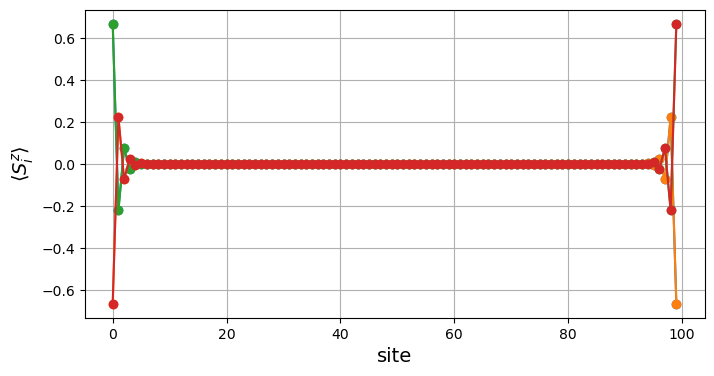

In [659]:
fig,ax = subplots(figsize=(8,4))

for expval in expval_sz
    ax.plot(expval, "-o")
end
ax.set_ylabel(L"$\langle S^z_i\rangle$", fontsize=14)
ax.set_xlabel("site", fontsize=14)
ax.grid()